# my-1st-try

In [1]:
#pip list
print("はじめ")

はじめ


# Vision-Trans-Former with keras(no Finetuning)

In [2]:
import os, sys, time
from datetime import datetime
import random

import numpy as np
import pandas as pd
from glob import glob

from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from PIL import Image

import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)

In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg19 import VGG19

import tensorflow as tf
import keras as K
from keras.utils import np_utils, to_categorical
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.initializers import TruncatedNormal, Constant
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from keras import models, layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


from efficientnet.keras import EfficientNetB4,EfficientNetB3,EfficientNetB2,EfficientNetB1,EfficientNetB0,EfficientNetB5,EfficientNetB6,EfficientNetB7


Using TensorFlow backend.


In [4]:
# config
data_seed = 94
EPOCHS = 150
PATCH_SIZE = 4
BATCH_SIZE = 20 #100
IMAGE_SIZE = 314 #512 #64 #225
CH_NUM = 3

                            
#VALID_SPLIT = 0.2                        #学習中のtrain-data分割割合
opt = "adam"                             #最適化関数は何使う？"SDG","adam","RMSprop", "nadam", "adadelta"
LOSS = "categorical_crossentropy"        #損失関数はどうする？"categorical_crossentropy","sparse_categorical_crossentropy",""
METRICS = ["accuracy"]                   #最適化する計量は？"accuracy","",""

In [5]:
# 画像を取得する関数(RGBで処理したい)
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    # リサイズする
    im_rgb = cv2.resize(im_rgb , (IMAGE_SIZE, IMAGE_SIZE))
    return im_rgb


# kaggle用
# 画像のful-pathリスト作成
test_imgs = glob("../input/cassava-leaf-disease-classification/test_images/**.jpg")
# 画像のful-pathリスト作成
imgs = glob("../input/cassava-leaf-disease-classification/train_images/**.jpg")
# 画像の名称リスト
train_img_list = os.listdir(os.path.join("../input/cassava-leaf-disease-classification/train_images"))
# 画像のラベル名リスト
train_label = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
# 学習データ作成準備
samples_df = shuffle(train_label, random_state=94)
samples_df["label"] = samples_df["label"].astype("str")
samples_df.head()

# 画像のラベル詳細について
#desease_list = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json")

In [6]:
# local用
# 画像のful-pathリスト作成
test_imgs = glob("/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/test_images/**.jpg")
# 画像のful-pathリスト作成
imgs = glob("/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/train_images/**.jpg")
# 画像の名称リスト
train_img_list = os.listdir(os.path.join("/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/train_images"))
# 画像のラベル名リスト
train_label = pd.read_csv("/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/train.csv")
# 学習データ作成準備
samples_df = shuffle(train_label, random_state=94)
samples_df["label"] = samples_df["label"].astype("str")
samples_df.head()

# 画像のラベル詳細について
#desease_list = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json")

samples_train = samples_df
samples_val =samples_df

In [7]:
samples_train.head()

,image_id,label
13726,3456257914.jpg,4
7617,2355183188.jpg,3
15078,3708657911.jpg,0
167,102968016.jpg,3
16261,3928883065.jpg,0


In [8]:
imgs[0]

'/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/train_images\\1000201771.jpg'

In [9]:
# 学習データと評価データに分ける準備
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

In [10]:
training_df.shape, validation_df.shape

((17117, 2), (4280, 2))

In [11]:
print(training_df["label"].value_counts())
print(validation_df["label"].value_counts())

3    10573
4     2053
2     1909
1     1708
0      874
Name: label, dtype: int64
3    2585
4     524
1     481
2     477
0     213
Name: label, dtype: int64


# ランダムでサンプルデータから、学習セットを生成する

In [12]:
# training_dfのランダム生成関数
def train_data_gen(training_item_count, data_seed):
    global samples_train
    samples_train = shuffle(samples_train, random_state = data_seed)
    samples_train["label"] = samples_train["label"].astype("str")
    samples_train = samples_train[:training_item_count]
    
    return samples_train

# validation_dfのランダム生成関数
def val_data_gen(training_item_count, data_seed):
    global samples_val
    samples_val = shuffle(samples_val, random_state = data_seed)
    samples_valid = samples_val
    samples_valid["label"] = samples_valid["label"].astype("str")
    samples_valid = samples_valid[training_item_count:]
    
    return samples_valid

In [13]:
# 学習用の準備
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
target_size = (IMAGE_SIZE, IMAGE_SIZE)
dropout_rate = 0.4
classes_to_predict = sorted(training_df.label.unique())
CLASS = len(classes_to_predict)
print("クラス数は：", CLASS)

クラス数は： 5


In [14]:
training_df.head()

,image_id,label
13726,3456257914.jpg,4
7617,2355183188.jpg,3
15078,3708657911.jpg,0
167,102968016.jpg,3
16261,3928883065.jpg,0


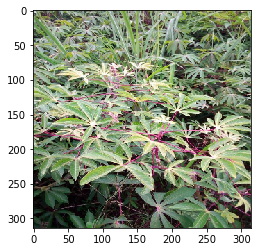

In [15]:
# テストデータを確認してみる
plt.imshow(get_img(test_imgs[0]))

In [16]:
tes_img = cv2.imread(test_imgs[0])
tes_img = cv2.resize(tes_img , (IMAGE_SIZE, IMAGE_SIZE))
tes_img.shape

(314, 314, 3)

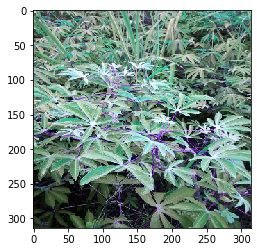

In [17]:
plt.imshow(tes_img)

In [18]:
#submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
submission = pd.read_csv("/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/sample_submission.csv")
submission.head()

,image_id,label
0,2216849948.jpg,4


# 学習画像を準備する部分

datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=".\train_imgs",
    x_col="image_id",
    y_col="label",
    class_mode="sparse",
    target_size=(32,32),
    batch_size=32)

参考のやつ
ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.15,
                                     cval = 0.,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.15,
                                     height_shift_range = 0.15,
                                     width_shift_range = 0.15) \

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    height_shift_range = 0.15,
    width_shift_range = 0.15
)

train_generator = train_datagen.flow_from_dataframe(
    #dataframe = training_df,
    dataframe = train_data_gen(training_item_count, data_seed),
    x_col='image_id',
    y_col='label',
    directory='/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/train_images/',
    target_size=target_size,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed = 94)


# Validation_datagenでもAugumentationをすれば、TTA的に若干の精度向上が見込まれる
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    #dataframe = validation_df,
    dataframe = val_data_gen(training_item_count, data_seed),
    x_col='image_id',
    y_col='label',
    directory='/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/train_images/',
    target_size=target_size,
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed = 94)

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 17116 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


In [20]:
print(tes_img.shape)

(314, 314, 3)


# Model-Setting

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Add, Activation, Input
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# 自作モデル_02_Vit
def MultiHead_SelfAttention(inputs, embed_dim, num_heads):
    projection_dim = embed_dim // num_heads
    batch_size = K.int_shape(inputs)[0]

    query = Dense(embed_dim)(inputs)
    key   = Dense(embed_dim)(inputs)
    value = Dense(embed_dim)(inputs)

    query = K.reshape(query, (batch_size, -1, num_heads, projection_dim))
    key   = K.reshape(key,   (batch_size, -1, num_heads, projection_dim))
    value = K.reshape(value, (batch_size, -1, num_heads, projection_dim))

    query = K.permute_dimensions(query, (0, 2, 1, 3))
    key   = K.permute_dimensions(key,   (0, 2, 1, 3))
    value = K.permute_dimensions(value, (0, 2, 1, 3))

    score = tf.matmul(query, key, transpose_b=True)
    score = score/K.sqrt(K.cast(projection_dim, 'float32'))
    weights = Activation('softmax')(score)

    attention = tf.matmul(weights, value)
    attention = K.permute_dimensions(attention, (0, 2, 1, 3))
    attention = K.reshape(attention, (batch_size, -1, embed_dim))
    output = Dense(embed_dim)(attention)
    return output

def TransformerBlock(inputs, embed_dim, num_heads, ff_dim):
    attn_output = MultiHead_SelfAttention(inputs, embed_dim, num_heads)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attn_output]))
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ffn_output]))

class Add_Embedding_Layer(tf.keras.layers.Layer):
    def __init__(self, num_patches=64, d_model=64, batch_size=16):
        super(Add_Embedding_Layer, self).__init__()
        self.batch_size = batch_size
        self.patch_emb = self.add_weight(shape=[1, 1, d_model], dtype=tf.float32)
        self.pos_emb = self.add_weight(shape=[1, num_patches+1, d_model], dtype=tf.float32)

    def call(self, input):
        patch_emb = K.repeat_elements(self.patch_emb, self.batch_size, axis=0)
        pos_emb = K.repeat_elements(self.pos_emb, self.batch_size, axis=0)
        return K.concatenate([input, patch_emb], axis=1) + pos_emb



def make_ViT(img_size = IMAGE_SIZE, ch_size = CH_NUM, patch_size = PATCH_SIZE,
             batch_size = BATCH_SIZE, num_layers = 4, d_model = IMAGE_SIZE,
             num_heads = 4, mlp_dim = 128, num_classes = CLASS):

    num_patches = (img_size // patch_size) ** 2
    patch_dim = ch_size * patch_size ** 2

    #inputs = Input(shape=(32, 32, 3))
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CH_NUM))
    
    x = Rescaling(1./255)(inputs)
    x = tf.nn.space_to_depth(x, patch_size)
    x = K.reshape(x, (-1, num_patches, patch_dim))
    x = Dense(d_model)(x)

    x = Add_Embedding_Layer(num_patches, d_model, batch_size)(x)
    for _ in range(num_layers):
        x = TransformerBlock(x, d_model, num_heads, mlp_dim)

    x = Dense(mlp_dim, activation=tfa.activations.gelu)(x[:, 0])
    x = Dropout(0.1)(x)
    y = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inputs, outputs=y)

model = make_ViT()
model.summary()

# 自作のモデル_01
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CH_NUM)))
model.add(layers.MaxPooling2D(2, 2))
# The second convolution
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
# The third convolution
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
# The fourth convolution
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
# Flatten the results to feed into a dense layer
model.add(layers.Flatten())
# 128 neuron in the fully-connected layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(CLASS, activation="softmax"))

model.summary()

In [21]:
#input = Input(shape=X_train[0].shape)
input = Input(shape=tes_img.shape)

#model_base = VGG16(include_top=False, weights="imagenet", input_tensor=input, classes=CLASS)
#model_base = ResNet50(include_top=False, weights="imagenet", input_tensor=input, input_shape=None, pooling=None, classes=CLASS)
#model_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input, input_shape=None, pooling=None, alpha=1.0, depth_multiplier=1, classes=CLASS)
#model_base = VGG19(include_top=False, weights='imagenet', input_tensor=input, input_shape=None, pooling=None, classes=CLASS)

# ここEfficientNet(weights='noisy-student'"imagenet"も試す)
model_base = EfficientNetB0(input_shape=input_shape, weights="imagenet", include_top=False)

#model = VGG16(include_top=False, weights="imagenet", input_shape=input)
#model_name = "VGG16-fine"
model_name = "efnB4-fine"
#model_name = "Resnet50-fine"

print("model取得完了")
model_base.summary()

model取得完了
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 314, 314, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 157, 157, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 157, 157, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 157, 157, 32) 0           stem_bn[0][0]                    
__________________________________________________________________________

In [22]:
# 畳み込みベースのvgg16を凍結せずに再学習層を残す
print("凍結するけど、再学習層を残す！")
model_base.trainable = True

# このフラグがFalseの層は凍結される
set_flg = False

# どの層まで凍結するか・・・。。
#VGG16は、block5_conv1
#resnet50は、res5c_branch2c ,res5c_branch2a
#efficientNetB4は、top_convか、block7b_project_conv、block7b_se_reduceあたり？？
# block6a_expand_convが、6の層をa以降を解凍する⇒メモリエラーで無理
# block7a_expand_conv、⇒メモリエラーで無理

for layer in model_base.layers:
    if layer.name == "top_conv":  #"block5_conv1"というレイヤー以下はすべて trainable を True とする。
        set_flg = True
    if set_flg == True:
        layer.trainable = True
        print("set trainable True 凍結しない！")
    else:
        layer.trainable = False
        print("set trainable False 凍結！")

# モデルの確認
model_base.summary()

凍結するけど、再学習層を残す！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！
set trainable False 凍結！


In [23]:
# 全結合層の追加
print("全結合層の追加")
model = models.Sequential()
model.add(model_base)
#model.add(layers.Flatten(input_shape=(1,1,500)))
#model.add(layers.Dense(500, activation='relu'))
#model.add(layers.Flatten(input_shape=(1,1,CLASS)))
#model.add(layers.Dense(CLASS, activation='relu'))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(CLASS, activation='softmax'))

# 全結合層の各初期化、正則化の設定はきちんとする必要がある
model.add(layers.Dense(CLASS, activation='softmax', kernel_initializer='uniform', kernel_regularizer=K.regularizers.l2(0.)))


print("FineTuneing!!")

全結合層の追加
FineTuneing!!


# めも
conv_base = VGG16(weights = 'imagenet' , include_top = False , input_tensor=input, classes=CLASS)
conv_base.trainable = False # Freeze VGG16 base
model_2 = Sequential()
model_2.add(conv_base)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(512 , activation = "relu"))
model_2.add(layers.Dense(units = 5 , activation = "softmax"))
model_2.summary()
model_2.compile(loss = LOSS, optimizer = opt, metrics = METRICS)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 10, 10, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 418,565
Non-trainable params: 3,637,404
_________________________________________________________________


In [25]:
model.compile(loss = LOSS, optimizer = opt, metrics = METRICS)

# 学習処理

In [26]:
es = EarlyStopping(monitor="accuracy", min_delta=0.000, patience=20, verbose=1, mode='auto')

In [27]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [28]:
STEP_SIZE_VALID,STEP_SIZE_TRAIN

(214, 855)

In [29]:
training_df.shape, validation_df.shape

((17117, 2), (4280, 2))

In [30]:
print(tf.__version__)

2.2.0


In [31]:
# GPU使えているよね？？
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15817142242691660595,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14418439686849842048
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4847737241
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6603049422214480534
 physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10462284217008671714
 physical_device_desc: "device: XLA_GPU device"]

In [32]:
# メモリ制限するらしい
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

print(tf.__version__)
gpu_id = 0

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')

# 使うGPUの設定
tf.config.set_visible_devices(physical_devices[gpu_id], 'GPU')

# 動的メモリアロケート設定
tf.config.experimental.set_memory_growth(physical_devices[gpu_id], False)

In [33]:
# チェックポイントで定期的にモデルを保存する
# ファイル名に(`str.format`を使って)エポック数を埋め込む
from keras.callbacks import ModelCheckpoint

#checkpoint_path = "/Users/kushi/TechLife/kaggle_road/06_cassava/my_models/cp-{epoch:04d}.ckpt"
checkpoint_path = "/Users/kushi/TechLife/kaggle_road/06_cassava/my_models/cp-{epoch:04d}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath = checkpoint_path, 
                                monitor='val_loss', 
                                verbose=0, 
                                save_best_only=False, 
                                save_weights_only=False, 
                                mode='min', 
                                period=1)
hist = History()

In [34]:
T = time.time()
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=[es, cp_callback, hist],
                              shuffle=True,
                              workers=20
                             )

print("学習の処理時間：", str(time.time() - T), " [sec]")

Epoch 1/150
855/855 [==============================] - 128s 149ms/step - loss: 0.7889 - accuracy: 0.7140 - val_loss: 1.1400 - val_accuracy: 0.6551
Epoch 2/150
855/855 [==============================] - 122s 142ms/step - loss: 0.6872 - accuracy: 0.7501 - val_loss: 1.1620 - val_accuracy: 0.6652
Epoch 3/150
855/855 [==============================] - 122s 142ms/step - loss: 0.6624 - accuracy: 0.7641 - val_loss: 1.0217 - val_accuracy: 0.6748
Epoch 4/150
855/855 [==============================] - 122s 142ms/step - loss: 0.6376 - accuracy: 0.7673 - val_loss: 1.0602 - val_accuracy: 0.6722
Epoch 5/150
855/855 [==============================] - 122s 142ms/step - loss: 0.6238 - accuracy: 0.7753 - val_loss: 1.0483 - val_accuracy: 0.6715
Epoch 6/150
855/855 [==============================] - 122s 142ms/step - loss: 0.6176 - accuracy: 0.7773 - val_loss: 1.3438 - val_accuracy: 0.6638
Epoch 7/150
855/855 [==============================] - 122s 142ms/step - loss: 0.6004 - accuracy: 0.7833 - val_loss: 1

KeyboardInterrupt: 

In [35]:
# 評価用画像について
test_imgs[0]

'/Users/kushi/TechLife/kaggle_road/06_cassava/dataset/test_images\\2216849948.jpg'

(314, 314, 3)


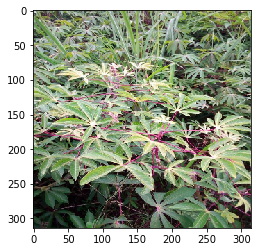

In [36]:
tes00 = get_img(test_imgs[0])
plt.imshow(tes00)
print(tes00.shape)

In [37]:
tes01 = tes00[np.newaxis,:,:,:]
print(tes01.shape)

(1, 314, 314, 3)


In [38]:
pred = model.predict(tes01)

In [39]:
result = np.argmax(pred)
print(result)
print(pred)

3
[[0.         0.         0.00101855 0.9989814  0.        ]]


In [40]:
# 学習後のモデルを丸ごと保存！
model.save("/Users/kushi/TechLife/kaggle_road/06_cassava/my_models/model.h5", include_optimizer=False)

In [41]:
# histは、callbackで設定してる変数
#hist_df = pd.DataFrame(history.history)
hist_df = pd.DataFrame(hist.history)
hist_df.to_csv("/Users/kushi/TechLife/kaggle_road/06_cassava/my_models/history.csv")

In [42]:
hist_df.head(20)

,val_loss,val_accuracy,loss,accuracy
0,1.139956,0.655140,0.788904,0.714027
1,1.162021,0.665187,0.686981,0.750058
2,1.021659,0.674766,0.662550,0.764097
3,1.060249,0.672196,0.637611,0.767314
4,1.048303,0.671495,0.623845,0.775322
5,1.343773,0.663785,0.617637,0.777264
6,1.259865,0.670327,0.600489,0.783283


In [43]:
# Acc画像の保存
plt.figure()
hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig(os.path.join("/Users/kushi/TechLife/kaggle_road/06_cassava/my_models/", "acc.png"))
plt.close()

<Figure size 432x288 with 0 Axes>

In [44]:
# loss画像の保存
plt.figure()
hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(os.path.join("/Users/kushi/TechLife/kaggle_road/06_cassava/my_models/", "loss.png"))
plt.close()

<Figure size 432x288 with 0 Axes>

In [45]:
# train_labelのデータフレームを表示、なぜか先頭の1枚目が無かったので削除する
print(train_label.shape)

train_label2 = train_label[1:]
train_label2.shape
train_label2 =train_label2.reset_index()

(21397, 2)


In [46]:
train_label2.head()

,index,image_id,label
0,1,1000201771.jpg,3
1,2,100042118.jpg,1
2,3,1000723321.jpg,1
3,4,1000812911.jpg,3
4,5,1000837476.jpg,3


In [47]:
10%10

0

In [48]:
# 混合行列
# 全データやると、だいたい560secかかるよ！
T = time.time()
pred_list = []
i=0
for i in range(len(imgs)//1):
    im = get_img(imgs[i])
    #print(imgs[i])
    im = im[np.newaxis, :, :, :]
    pred = model.predict(im)
    pred = np.argmax(pred)
    #print(pred)
    
    if i == 0:
        pred_list = pred
    elif i != 0:
        pred_list = np.append(pred_list, pred)
    
    if i % 100 == 0:
        print("かうんと", str(i))
    #print(pred_list)
print("処理時間：", str(time.time() - T), " [sec]")    
#print(confusion_matrix(y_true_multi, y_pred_multi))

かうんと 0
かうんと 100
かうんと 200
かうんと 300
かうんと 400
かうんと 500
かうんと 600
かうんと 700
かうんと 800
かうんと 900
かうんと 1000
かうんと 1100
かうんと 1200
かうんと 1300
かうんと 1400
かうんと 1500
かうんと 1600
かうんと 1700
かうんと 1800
かうんと 1900
かうんと 2000
かうんと 2100
かうんと 2200
かうんと 2300
かうんと 2400
かうんと 2500
かうんと 2600
かうんと 2700
かうんと 2800
かうんと 2900
かうんと 3000
かうんと 3100
かうんと 3200
かうんと 3300
かうんと 3400
かうんと 3500
かうんと 3600
かうんと 3700
かうんと 3800
かうんと 3900
かうんと 4000
かうんと 4100
かうんと 4200
かうんと 4300
かうんと 4400
かうんと 4500
かうんと 4600
かうんと 4700
かうんと 4800
かうんと 4900
かうんと 5000
かうんと 5100
かうんと 5200
かうんと 5300
かうんと 5400
かうんと 5500
かうんと 5600
かうんと 5700
かうんと 5800
かうんと 5900
かうんと 6000
かうんと 6100
かうんと 6200
かうんと 6300
かうんと 6400
かうんと 6500
かうんと 6600
かうんと 6700
かうんと 6800
かうんと 6900
かうんと 7000
かうんと 7100
かうんと 7200
かうんと 7300
かうんと 7400
かうんと 7500
かうんと 7600
かうんと 7700
かうんと 7800
かうんと 7900
かうんと 8000
かうんと 8100
かうんと 8200
かうんと 8300
かうんと 8400
かうんと 8500
かうんと 8600
かうんと 8700
かうんと 8800
かうんと 8900
かうんと 9000
かうんと 9100
かうんと 9200
かうんと 9300
かうんと 9400
かうんと 9500
かうんと 9600
かうんと 9700
かうんと 9800
かうんと 9900
かうんと 10000
か

In [49]:
pred_list.shape

(21396,)

In [50]:
pred_list[:100]

array([4, 2, 4, 1, 1, 2, 2, 1, 3, 2, 1, 2, 1, 3, 2, 1, 3, 2, 3, 4, 2, 2,
       2, 2, 4, 2, 1, 2, 2, 2, 2, 4, 2, 2, 1, 2, 3, 2, 2, 2, 1, 0, 2, 1,
       2, 2, 1, 1, 2, 3, 2, 3, 1, 1, 4, 2, 2, 2, 2, 3, 1, 1, 2, 3, 2, 1,
       2, 3, 4, 2, 2, 1, 2, 1, 2, 3, 3, 4, 1, 1, 3, 3, 3, 1, 2, 4, 2, 1,
       2, 4, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2], dtype=int64)

In [51]:
pred_list_df = pd.DataFrame(pred_list)
#train_label2 = pd.DataFrame(train_label2)
pred_list_df.columns = ["pred"]
pred_list_df.astype(int)
print(pred_list_df.shape)
print(train_label2.shape)

(21396, 1)
(21396, 3)


In [52]:
train_label2.head()

,index,image_id,label
0,1,1000201771.jpg,3
1,2,100042118.jpg,1
2,3,1000723321.jpg,1
3,4,1000812911.jpg,3
4,5,1000837476.jpg,3


In [53]:
pred_list_df.head()

,pred
0,4
1,2
2,4
3,1
4,1


In [54]:
pred_list_df["pred"].value_counts()

2    10998
1     5060
3     2880
4     2318
0      140
Name: pred, dtype: int64

In [55]:
train_label2["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1086
Name: label, dtype: int64

In [56]:
print(type(pred_list_df))
print(type(train_label2))
print("pred_list_df", 
      pred_list_df.dtypes)

print("train_label2",
      train_label2.dtypes)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
pred_list_df pred    int64
dtype: object
train_label2 index        int64
image_id    object
label        int64
dtype: object


In [57]:
result_df = pd.concat([train_label2, pred_list_df], axis=1)
print(result_df.dtypes)
print(result_df.shape)

index        int64
image_id    object
label        int64
pred         int64
dtype: object
(21396, 4)


In [58]:
result_df.head(30)

,index,image_id,label,pred
0,1,1000201771.jpg,3,4
1,2,100042118.jpg,1,2
2,3,1000723321.jpg,1,4
3,4,1000812911.jpg,3,1
4,5,1000837476.jpg,3,1
5,6,1000910826.jpg,2,2
6,7,1001320321.jpg,0,2
7,8,1001723730.jpg,4,1
8,9,1001742395.jpg,3,3
9,10,1001749118.jpg,3,2


In [59]:
result_df.to_csv("/Users/kushi/TechLife/kaggle_road/06_cassava/my_models/Add_Result.csv")

In [60]:
# 混合行列
cm = confusion_matrix(result_df["label"], result_df["pred"])
print(cm)

[[   8  275  548  137  118]
 [  18  570  996  303  302]
 [  25  537 1233  307  284]
 [  70 3017 6998 1793 1280]
 [  19  661 1223  340  334]]


In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


In [62]:
print(accuracy_score(result_df["label"], result_df["pred"]))
print(precision_score(result_df["label"], result_df["pred"], average="macro"))
print(recall_score(result_df["label"], result_df["pred"], average='macro'))
print(f1_score(result_df["label"], result_df["pred"], average='macro'))

0.18405309403626846
0.20971230968431467
0.210079759314913
0.14292464760860207


In [63]:
print(classification_report(result_df["label"], result_df["pred"]))

              precision    recall  f1-score   support

           0       0.06      0.01      0.01      1086
           1       0.11      0.26      0.16      2189
           2       0.11      0.52      0.18      2386
           3       0.62      0.14      0.22     13158
           4       0.14      0.13      0.14      2577

    accuracy                           0.18     21396
   macro avg       0.21      0.21      0.14     21396
weighted avg       0.43      0.18      0.19     21396



In [ ]:
end

In [ ]:
# 学習用
#history = model.fit(train_generator,
##                  epochs = EPOCHS, 
#                 validation_data=validation_generator)

In [ ]:
x_test.shape

In [ ]:
#decay_steps = int(round(len(training_df)/batch_size))*epochs
#cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.2)

#callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [ ]:
pred = model.predict(x_test, batch_size=batch_size)

In [ ]:
for i in range(20):
    print(np.argmax(pred[i]), "：確率は　", np.max(pred[i]), "=======正解⇒", np.argmax(y_test[i]))

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
print(cm)

In [ ]:
# 学習中の損失係数とAccuracyを可視化
fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)